Idea here is to make a 2 param NN (x,y,loss), then do a grid search where we init model, do one epoch, record results. Then contour it.

So first I need something to convert it to features.... then I have a linear(3) convert 3 features to one thing...

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from tqdm import tqdm_notebook as tqdm
%pylab inline
import pickle
import itertools

Populating the interactive namespace from numpy and matplotlib


In [17]:
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [18]:
cuda=False
seed=0
batch_size=512

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [19]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=args.test_batch_size, shuffle=True, **kwargs)

# Model

In [20]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.sigmoid(x)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-3)


# Pretrain

In [ ]:
epochs=100
for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        # reduce this to a binary problem
        target = (target>5).type(torch.FloatTensor)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.data[0]))

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 1 [11232/60000 (99%)]	Loss: 0.692205
Train Epoch: 2 [11232/60000 (99%)]	Loss: 0.689743
Train Epoch: 3 [11232/60000 (99%)]	Loss: 0.692480
Train Epoch: 4 [11232/60000 (99%)]	Loss: 0.693990
Train Epoch: 5 [11232/60000 (99%)]	Loss: 0.683959
Train Epoch: 6 [11232/60000 (99%)]	Loss: 0.672049
Train Epoch: 7 [11232/60000 (99%)]	Loss: 0.682046


In [ ]:
model_path='data/model.pickle'
torch.save(model, model_path)

# Explore

In [9]:
model2 = torch.load(model_path)
# freeze all except last layer
mlayers = [
    model2.conv1,
    model2.conv2,
    model2.fc1
]
for layer in mlayers:
    for param in layer.parameters():
          param.requires_grad = False

In [ ]:
# minima = model2.conv2.weights.data[:]
# minima_z = 

In [13]:
# grid search
points = []
xs=torch.arange(-1,1,0.01)
ys=torch.arange(-1,1,0.01)
xys = list(itertools.product(xs,ys))
for x,y in tqdm(xys):
    
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

    # load again
#     model2 = torch.load(model_path)
    
    # freeze all except last layer
#     mlayers = [
#         model2.conv1,
#         model2.conv2,
#         model2.fc1
#     ]
#     for layer in mlayers:
#         for param in layer.parameters():
#               param.requires_grad = False

    # set last layer weights
    model2.fc2.weight.data =  torch.Tensor([x,y])

    # train a bit
    optimizer = optim.SGD(model.parameters(), lr=1e-3)

    z=0
    dz=0
    batches=0

    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        # reduce this to a binary problem
        target = (target>5).type(torch.FloatTensor)

#             optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
#             loss.backward()
#             optimizer.step()
#             print(model2.fc2.weight.grad)
        z += loss.data
        batches += 1 
        
        if batches>10:
            break

    z /= batches
    points.append([x,y,z.numpy()[0]])
#         print(points[-1])

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


KeyboardInterrupt: 

In [158]:
# save
pickle.dump(points, open('points.pickle','wb'))

In [16]:
# save
# points = pickle.load(open('points.pickle','rb'))

EOFError: Ran out of input

In [190]:

x,y,z = np.array(points).T

# scale lossses to they look OK
z=(z-z.min())*10000000
logzmax = np.log(z.max())
logzmax

5.1489900056320641

In [191]:
# now reshape into square arrays
x = x.reshape((len(xs),len(ys)))
y = y.reshape((len(xs),len(ys)))
z = z.reshape((len(xs),len(ys)))

/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


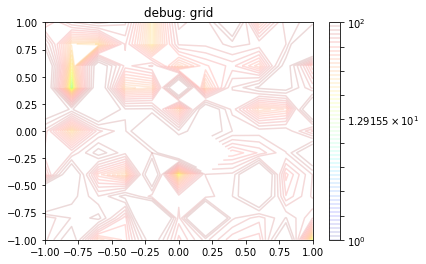

In [192]:
ax = plt.gca()
cm=ax.contour(x, y, z, levels=np.logspace(0, logzmax//2, 55), norm=LogNorm(), cmap=plt.cm.jet, alpha=0.15)
plt.colorbar(cm)
# ax.plot(*minima_, 'r*', markersize=10)
# ax.plot(*problem.x0, 'r+', markersize=10)
plt.title('minst: a slice of the problem surface for 2 neurons')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.show()